# 3-D Data Visualization Notebook

### READ ME :-)
- The purpose of this notebook is to produce visualizations of the topoclusters/events and display them with tracks.
- For now, this only works with central tracks as we need to solve for z coordinates of the end caps so everything must be below .7 eta in the barrel calo.
- Basic event pre-seletion is done here. In the future, this should be moved to another notebook. The goal is to make this code robust enough such that any event can be input, and the tracks and cluster will show up in either the barrel calo or the end caps. More work is needed to involve other calo sampling layers (presampler, FCal, Gaps, etc.)

In [1]:
# python
import numpy as np
import time as t

# physics
import uproot as ur
import awkward as ak
import vector as vec
print("Awkward version: "+str(ak.__version__))
print("Uproot version: "+str(ur.__version__))
print("Vector version: "+str(vec.__version__))

# visualization tools
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
# import k3d

Awkward version: 1.7.0
Uproot version: 4.1.9
Vector version: 0.8.4


#### Branch Info

In [2]:
track_branches = ['trackEta_EMB1', 'trackPhi_EMB1', 'trackEta_EMB2', 'trackPhi_EMB2', 'trackEta_EMB3', 'trackPhi_EMB3',
                  'trackEta_TileBar0', 'trackPhi_TileBar0', 'trackEta_TileBar1', 'trackPhi_TileBar1',
                  'trackEta_TileBar2', 'trackPhi_TileBar2']

event_branches = ["cluster_nCells", "cluster_cell_ID", "cluster_cell_E", 'cluster_nCells', "nCluster", "eventNumber",
                  "nTrack", "nTruthPart", "truthPartPdgId", "cluster_Eta", "cluster_Phi", 'trackPt', 'trackP',
                  'trackMass', 'trackEta', 'trackPhi', 'truthPartE', 'cluster_ENG_CALIB_TOT', "cluster_E", 'truthPartPt']

geo_branches = ["cell_geo_ID", "cell_geo_eta", "cell_geo_phi", "cell_geo_rPerp", "cell_geo_sampling"]

### Functions

In [3]:
def DeltaR(coords, ref):
    ''' Straight forward function, expects Nx2 inputs for coords, 1x2 input for ref '''
    ref = np.tile(ref, (len(coords[:,0]), 1))
    DeltaCoords = np.subtract(coords, ref)
    return np.sqrt(DeltaCoords[:,0]**2 + DeltaCoords[:,1]**2) 

## Notes, change this to accept special branches to convert to numpy arrays!!
def dict_from_event_tree(_event_tree, _branches):
    ''' The purpose for this separate function is to load np arrays where possible. '''
    _special_keys = ["nCluster", "eventNumber", "nTrack", "nTruthPart"]
    _dict = dict()
    for _key in _branches:
        if _key in _special_keys:
            _branch = _event_tree.arrays(filter_name=_key)[_key].to_numpy()
        else:
            _branch = _event_tree.arrays(filter_name=_key)[_key]
        _dict[_key] = _branch
    return _dict

def dict_from_tree_branches(_tree, _branches):
    ''' Helper function to put event data in branches to make things easier to pass to functions,
    pretty self explanatory. '''
    _dict = dict()
    for _key in _branches:
        _branch = _tree.arrays(filter_name=_key)[_key]
        _dict[_key] = _branch
    return _dict

def dict_from_tree_branches_np(_tree, _branches):
    ''' Helper function to put event data in branches to make things easier to pass to functions,
    pretty self explanatory. This always returns np arrays in the dict. '''
    _dict = dict()
    for _key in _branches:
        _branch = np.ndarray.flatten(_tree.arrays(filter_name=_key)[_key].to_numpy())
        _dict[_key] = _branch
    return _dict

def find_index_1D(values, dictionary):
    ''' Use a for loop and a dictionary. _values are the IDs to search for. _dict must be in format 
    (cell IDs: index) '''
    idx_vec = np.zeros(len(values), dtype=np.int32)
    for i in range(len(values)):
        idx_vec[i] = dictionary[values[i]]
    return idx_vec

def to_xyz(_coords):
    ''' Simple geometric conversion to xyz from eta, phi, rperp (READ: in this order)
    There is an elegant way to generalize this to be flexible for 1d or 2d, for now 2d
    Inputs: np array of shape (N, 3) where columns are [eta, phi, rPerp]
    Outputs: np array of shape (N, 3) where columns are [x,y,z] '''
    _eta = _coords[:,0]
    _phi = _coords[:,1]
    _rperp = _coords[:,2]
    _theta = 2*np.arctan( np.exp(-_eta) )
    
    cell_x = _rperp*np.cos(_phi)
    cell_y = _rperp*np.sin(_phi)
    cell_z = _rperp/np.tan(_theta)
    
    return np.column_stack([cell_x,cell_y,cell_z])

## Load Data
#### Events

In [5]:
events = ext_datapath+'user.angerami.24559744.OutputStream._000001.root'
my_event = ur.open(events)
my_event.keys()

['EventTree;1', 'CellGeo;1']

In [6]:
event_tree = my_event['EventTree']

In [7]:
event_dict = dict_from_event_tree(event_tree, event_branches)

In [8]:
track_dict = dict_from_tree_branches(event_tree, track_branches)

#### Geometry

In [9]:
CellGeo_tree = my_event['CellGeo']
CellGeo_tree.show(interpretation_width=60)

geo_dict = dict_from_tree_branches_np(CellGeo_tree, geo_branches)
idx_dict = dict( zip( geo_dict['cell_geo_ID'], np.arange(len(geo_dict['cell_geo_ID'])) ) )

name                 | typename                 | interpretation                                              
---------------------+--------------------------+-------------------------------------------------------------
cell_geo_ID          | std::vector<uint64_t>    | AsJagged(AsDtype('>u8'), header_bytes=10)
cell_geo_sampling    | std::vector<uint16_t>    | AsJagged(AsDtype('>u2'), header_bytes=10)
cell_geo_eta         | std::vector<float>       | AsJagged(AsDtype('>f4'), header_bytes=10)
cell_geo_phi         | std::vector<float>       | AsJagged(AsDtype('>f4'), header_bytes=10)
cell_geo_rPerp       | std::vector<float>       | AsJagged(AsDtype('>f4'), header_bytes=10)
cell_geo_deta        | std::vector<float>       | AsJagged(AsDtype('>f4'), header_bytes=10)
cell_geo_dphi        | std::vector<float>       | AsJagged(AsDtype('>f4'), header_bytes=10)
cell_geo_volume      | std::vector<float>       | AsJagged(AsDtype('>f4'), header_bytes=10)
cell_geo_sigma       | std::vector<float> 

## Event Cuts

In [10]:
# create ordered list of events to use for index slicing
nEvents = len(event_dict['eventNumber'])
all_events = np.arange(0,nEvents,1,dtype=np.int32)
print('All events, shape '+str(all_events.shape))

All events, shape (20000,)


#### Tracks

In [393]:
# SINGLE TRACK CUT
single_track_mask = event_dict['nTrack'] == np.full(nEvents, 1)
filtered_event = all_events[single_track_mask]
print('Single Track Indices, shape '+str(np.shape(filtered_event)))
print(filtered_event[0:20])

# CENTRAL TRACK CUT
trackEta_EMB1 = ak.flatten(track_dict['trackEta_EMB1'][filtered_event]).to_numpy()
central_track_mask = np.abs(trackEta_EMB1) < 0.7
filtered_event = filtered_event[central_track_mask]
# Save this for processing track only files later
central_single_tracks = filtered_event
print('Central track indices, shape '+str(np.shape(filtered_event)))
print(filtered_event[0:20])

Single Track Indices, shape (12122,)
[ 0  1  4  5  6  8 10 11 13 14 16 19 20 23 24 26 27 29 31 32]
Central track indices, shape (3827,)
[ 1  4 11 14 24 27 29 32 41 42 44 46 48 54 76 79 83 84 89 90]


#### Cluster Track Matching

In [394]:
clusters_tracks = []

for _evt in filtered_event[:]:
    # pull cluster number, don't need zero as it's loaded as a np array
    _nClust = event_dict["nCluster"][_evt]

    ## DELTA R ##
    if _nClust != 0:
        # pull coordinates of tracks and clusters from event
        # we can get away with the zeroth index because we are working with single track events
        _trackCoords = np.array([event_dict["trackEta"][_evt][0],
                                 event_dict["trackPhi"][_evt][0]])
        _clusterCoords = np.stack((event_dict["cluster_Eta"][_evt].to_numpy(),
                                   event_dict["cluster_Phi"][_evt].to_numpy()), axis=1)

        _DeltaR = DeltaR(_clusterCoords, _trackCoords)
        _DeltaR_mask = _DeltaR < 0.2
        
        if np.any(_DeltaR_mask):
            clusters_tracks.append(_evt)

print('Central tracks with matched clusters, shape '+str(np.shape(clusters_tracks)))
print(clusters_tracks[0:20])

Central tracks with matched clusters, shape (3039,)
[1, 4, 11, 14, 24, 27, 29, 32, 42, 44, 46, 54, 76, 79, 83, 84, 89, 90, 95, 99]


## Event Choice

In [415]:
# randomn interger to use for indexing
event = clusters_tracks[np.random.randint(0,len(clusters_tracks))]

In [425]:
event

18456

#### Load all clusters into a list
Each cluster is represented as an array object with varying length in a list. The order of the columns is as follows:
### [Energy, Eta, Phi, rPerp, Sample Layer]

In [416]:
ak_cluster_cell_ID = event_dict['cluster_cell_ID'][event]
cell_geo_ID = geo_dict['cell_geo_ID']
nClust = len(ak_cluster_cell_ID)

clusters = []
for j in range(nClust):
    
    # find cluster size
    _nInClust = len(ak_cluster_cell_ID[j])

    # make empty array of cluster info
    _cluster = np.zeros((_nInClust, 5))
    
    # index matching
    _indices = find_index_1D(ak_cluster_cell_ID[j].to_numpy(), idx_dict)

    _cluster[:,0] = event_dict["cluster_cell_E"][event][j].to_numpy()
    _cluster[:,1] = geo_dict["cell_geo_eta"][_indices]
    _cluster[:,2] = geo_dict["cell_geo_phi"][_indices]
    _cluster[:,3] = geo_dict["cell_geo_rPerp"][_indices]
    _cluster[:,4] = geo_dict["cell_geo_sampling"][_indices]
    
    clusters.append(_cluster)

print('Number of Clusters: '+str(len(clusters)))
print('Number in each:')
for n in range(len(clusters)):
    print(len(clusters[n]))

Number of Clusters: 5
Number in each:
399
88
10
11
11


### Tracks

In [417]:
barrel_layer_rPerp = np.array([1540., 1733., 1930., 2450., 3010., 3630.])

n_tracks = event_dict['nTrack'][event]
print('Number of tracks: '+str(n_tracks))

tracks = []
for t in range(n_tracks):    
    track = np.zeros(12)
    i = 0
    for _key in track_branches:
        track[i] = track_dict[_key][event][t]
        i += 1
    track = np.reshape(track, (6,2))
    trackP = np.full(6, event_dict['trackP'][event][t])
    track = np.column_stack((trackP, track, barrel_layer_rPerp, np.array([1,2,3,12,13,14])))
    tracks.append(track)

Number of tracks: 1


### Data Conversions

In [418]:
cluster_xyz = []
for i in range(len(clusters)):
    _xyz = to_xyz(clusters[i][:,1:4])
    cluster_xyz.append(_xyz)

In [419]:
tracks_xyz = []
for i in range(len(tracks)):
    _xyz = to_xyz(tracks[i][:,1:4])
    tracks_xyz.append(_xyz)

## 3-D Visualizations

In [420]:
# keep making this bigger as the events go on
colors = ['blue', 'red', 'gold', 'darkturquoise', 'indigo', 'crimson', 'orange']

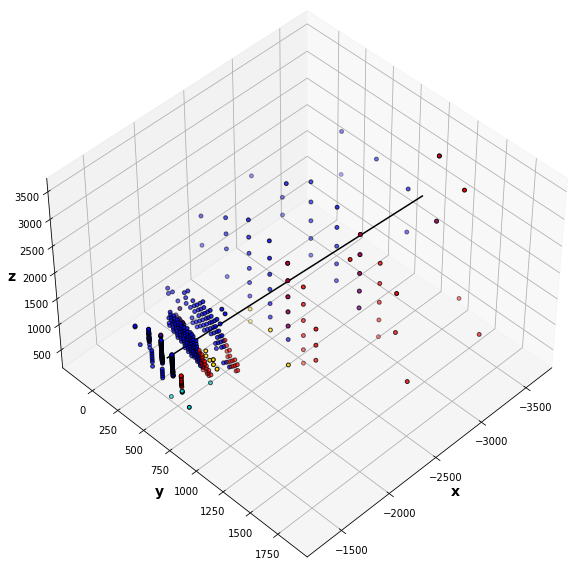

In [443]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=45, azim=45)
for i in range(len(cluster_xyz)):
    ax.scatter(cluster_xyz[i][:,0], cluster_xyz[i][:,1], cluster_xyz[i][:,2], color=colors[i],
              s=15, edgecolor='black')
for i in range(len(tracks_xyz)):
    ax.plot(tracks_xyz[i][:,0], tracks_xyz[i][:,1], tracks_xyz[i][:,2], color='black')
# ax.set_xlim(-500,-3000)
# ax.set_ylim(-3000,-500)
# ax.set_zlim(500,3500)
ax.set_xlabel('x', fontsize=14, fontweight='bold')
ax.set_ylabel('y', fontsize=14, fontweight='bold')
ax.set_zlabel('z', fontsize=14, fontweight='bold')
plt.tight_layout()
# plt.savefig('Plots/clusters_3d_scatter_elev30_azim65_wTrack_evt22_2021-06-01.png', format='png')
plt.show()

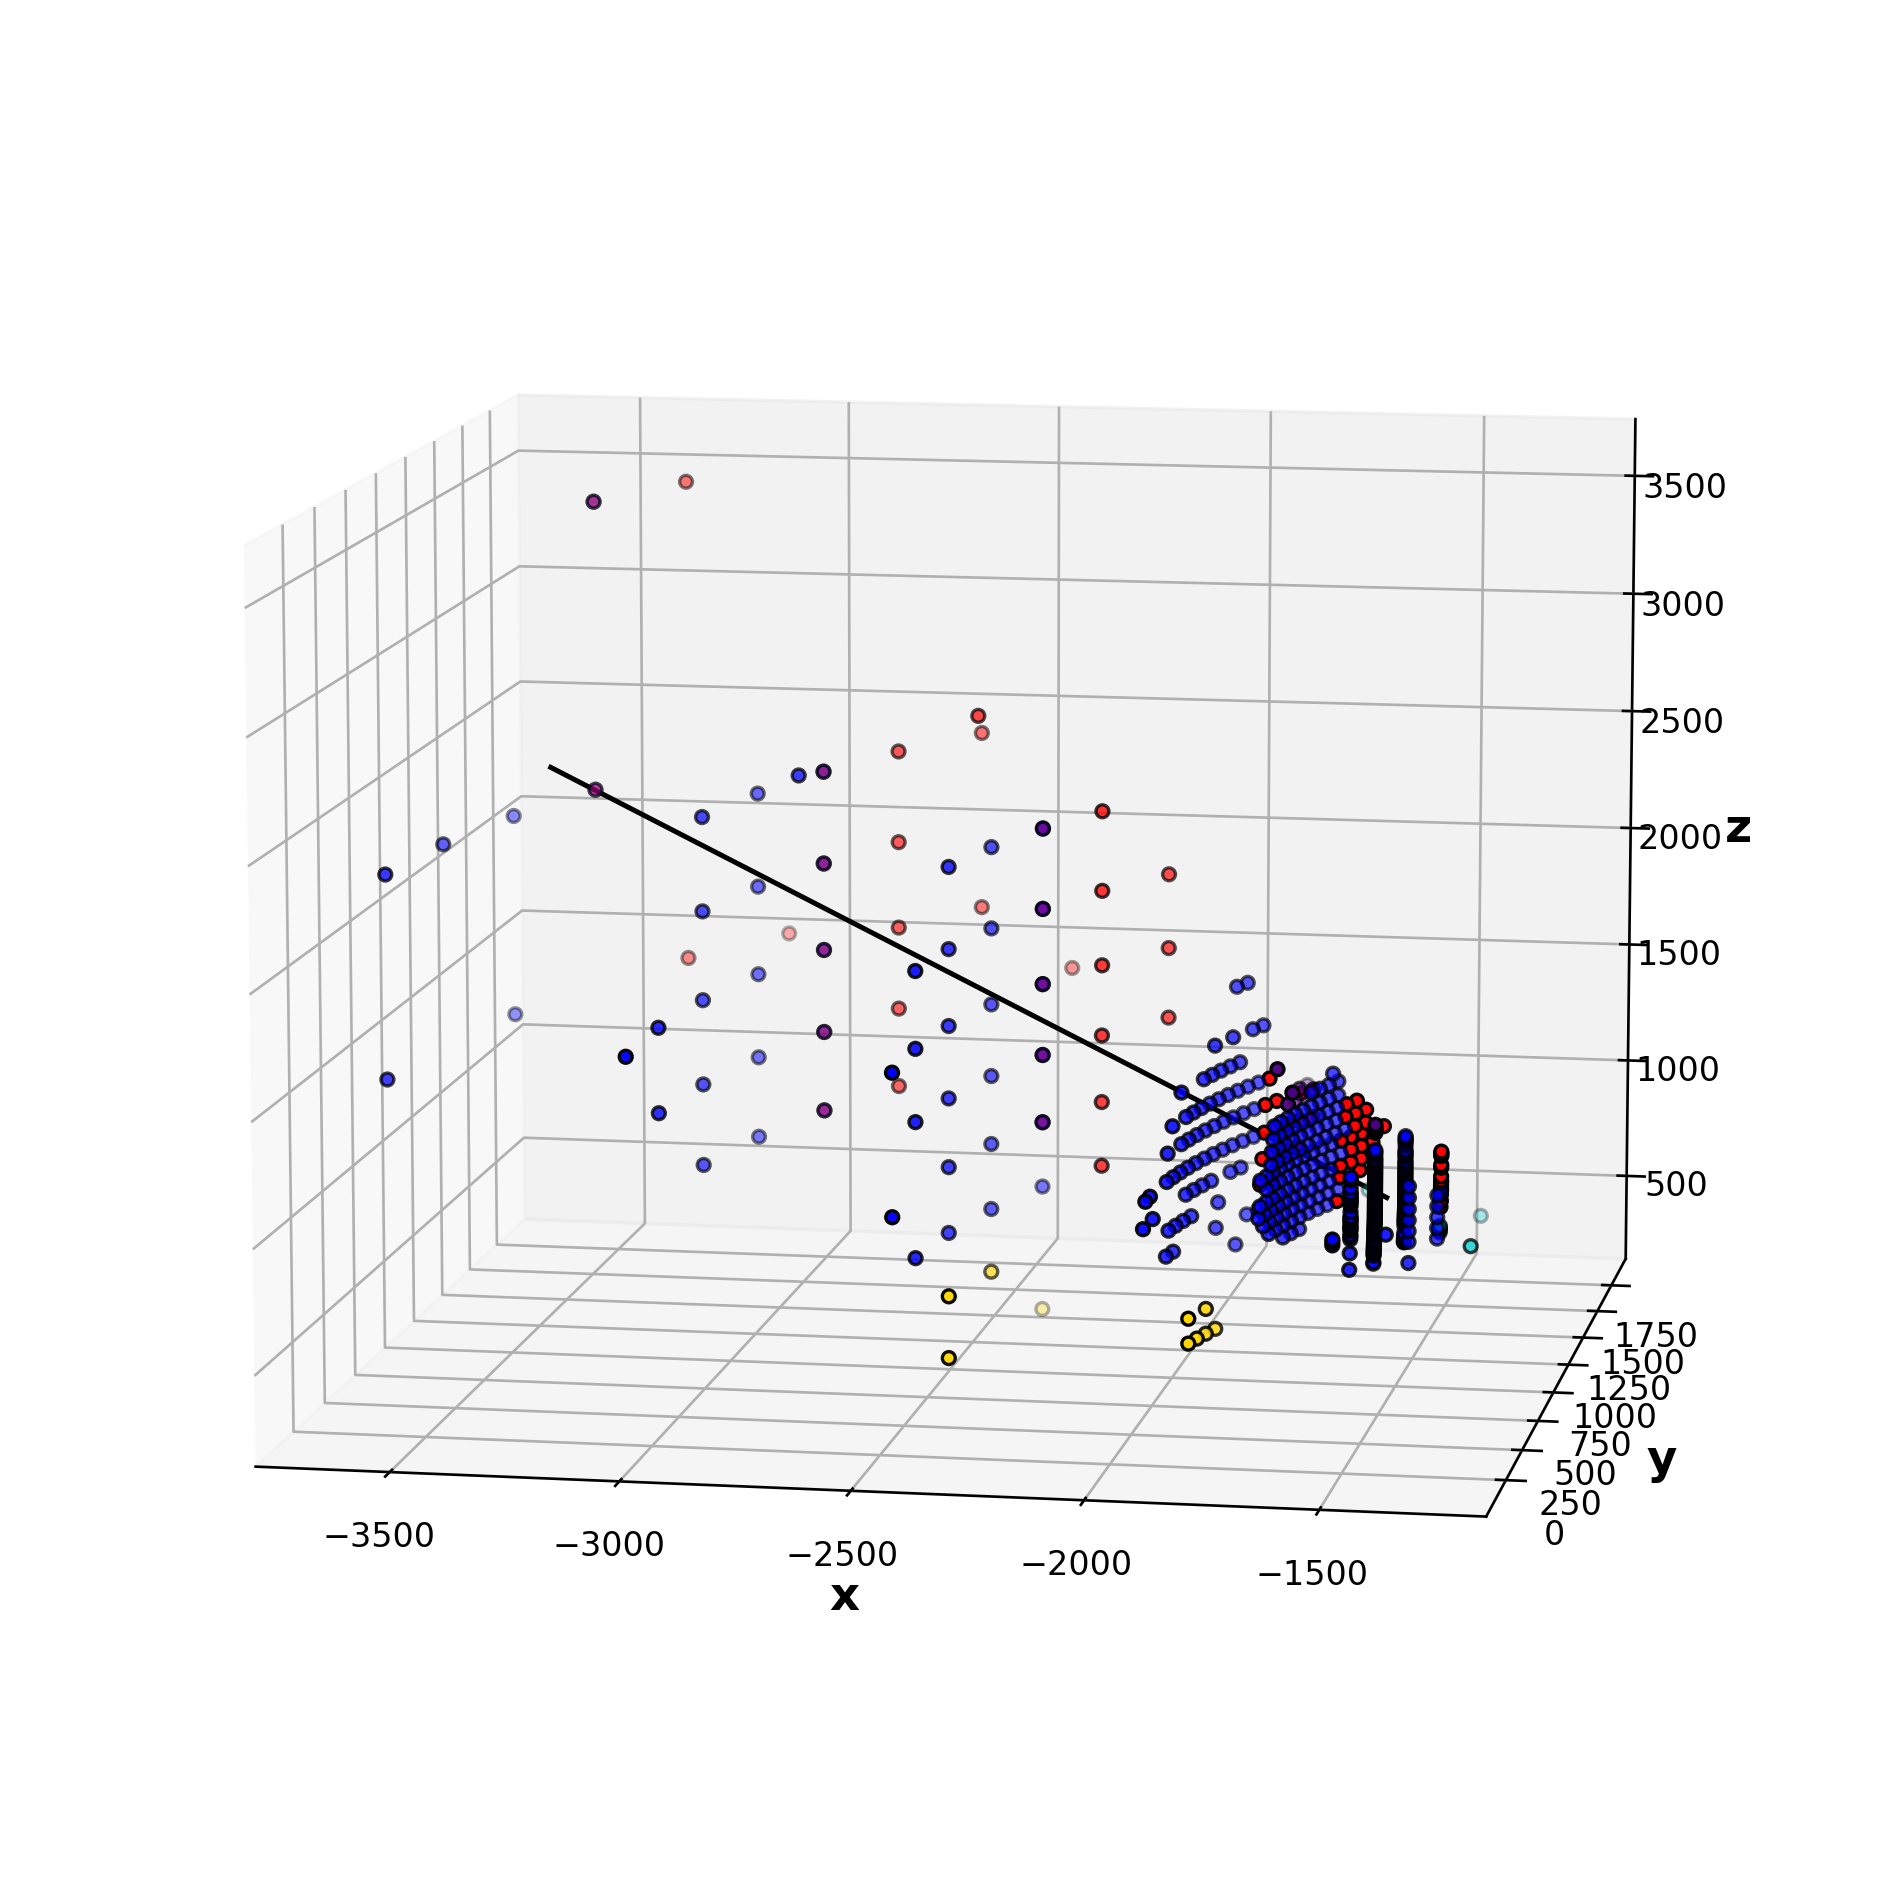

In [466]:
fig = plt.figure(figsize=(8,8), dpi=240)
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=10, azim=-80)
for i in range(len(cluster_xyz)):
    ax.scatter(cluster_xyz[i][:,0], cluster_xyz[i][:,1], cluster_xyz[i][:,2], color=colors[i],
              s=15, edgecolor='black')
for i in range(len(tracks_xyz)):
    ax.plot(tracks_xyz[i][:,0], tracks_xyz[i][:,1], tracks_xyz[i][:,2], color='black')
# ax.set_xlim(-1000,-3000)
# ax.set_ylim(-3000,-750)
# ax.set_zlim(500,3500)
ax.set_xlabel('x', fontsize=14, fontweight='bold')
ax.set_ylabel('y', fontsize=14, fontweight='bold')
ax.set_zlabel('z', fontsize=14, fontweight='bold')
plt.tight_layout()
# plt.savefig('Plots/clusters_3d_scatter_elev10_azim105_wTrack_evt22_2021-06-01.png', format='png')
plt.show()

## Solve for Geometric Cell Values
##### Note: move this to Data exploration notebook.
This is used to place the tracks later.
#### Create large array with all cluster cells

In [423]:
all_clusters = np.ndarray.copy(clusters[0])
for i in range(1,len(clusters)):
    all_clusters = np.vstack((all_clusters, clusters[i]))

#### Solve for average rPerp
This is for barrel events only at present

In [424]:
layer_rPerp = []
layer_filter = [1,2,3,12,13,14]
print(np.unique(all_clusters[:,4]))

for _layer in layer_filter:
    _mask = all_clusters[:,4] == _layer
    _rPerp_layer = all_clusters[_mask,3]
    layer_rPerp.append(np.mean(_rPerp_layer))
np.array(layer_rPerp)
print(np.round(layer_rPerp,2))

[ 0.  1.  2.  3. 12. 13. 14. 16.]
[1536.39 1728.56 1928.56 2450.   3006.36 3630.  ]
